#### Imports

In [1]:
import os
import torch

import numpy as cp # sticking with numpy for now
cp.random.seed(42)

import matplotlib.pyplot as plt
import scipy
from scipy import signal

#### ARMAX class

In [2]:
class ARMAX:
    def __init__(self, A, B, C, F, L):
        self.A = cp.array(A)
        self.B = cp.array(B)
        self.C = cp.array(C)
        self.F = cp.array(F)
        self.L = cp.array(L)
        # cp.random.seed(42)
    
    def simulate(self, n_samples, R=None, noise_std=0.1):
        Y = cp.zeros(n_samples)
        U = cp.zeros(n_samples)
        N = cp.random.normal(0, noise_std, n_samples)
        
        if R is None:
            R = cp.zeros(n_samples)
        
        max_order = max(len(self.A), len(self.B), len(self.C), len(self.F), len(self.L))
        
        for t in range(max_order, n_samples):
            Y[t] = (- cp.dot(self.A[1:], Y[t-1:t-len(self.A):-1]) 
                    + cp.dot(self.B, U[t-1:t-len(self.B)-1:-1])
                    + cp.dot(self.C, N[t:t-len(self.C):-1]))
            
            U[t] = (cp.dot(self.L, R[t:t-len(self.L):-1]) 
                    - cp.dot(self.F, Y[t:t-len(self.F):-1]))
        
        return Y, U, N, R
    
    def plot_results(self, Y, U, N, R):
        fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
        
        axs[0].plot(Y)
        axs[0].set_ylabel('Output (Y)')
        axs[0].set_title('ARMAX Closed-Loop Simulation Results')
        
        axs[1].plot(U)
        axs[1].set_ylabel('Input (U)')
        
        axs[2].plot(N)
        axs[2].set_ylabel('Noise (N)')
        
        axs[3].plot(R)
        axs[3].set_ylabel('Reference (R)')
        axs[3].set_xlabel('Time')
        
        plt.tight_layout()
        plt.show()

#### SPS indirect class

In [3]:
from sps_indirect import SPS_indirect_model, d_tfs

#### SPS confidence region for nth order system

##### get_conf_region()

In [4]:
def get_conf_region(region_bounds, granularity, model, n_a, n_b, C, L, F, Y, R):
    
    assert n_a + n_b == len(region_bounds)
    assert n_a + n_b == len(granularity)
    
    # Create a meshgrid for A and B values
    grid_axes = [cp.linspace(region_bounds[i][0], region_bounds[i][1], granularity[i]) for i in range(n_a+n_b)]
    grid_vals = cp.meshgrid(*grid_axes, indexing='ij')
    grid_vals = cp.array(grid_vals)

    flat_param_vals = [grid_vals[i].ravel() for i in range(n_a+n_b)]
    flat_param_vals = cp.array(flat_param_vals).T

    pts_in_conf_region = []
    n_pts = flat_param_vals.shape[0]
    for i in range(n_pts):

        point = flat_param_vals[i]
        A = cp.concatenate(([1], -point[:n_a]))
        B = cp.concatenate(([0],  point[n_a:]))
        G = (B, A)
        H = (C, A)
        
        # Check stability conditions
        G_tf = d_tfs(G)
        H_tf = d_tfs(H)
        L_tf = d_tfs(L)
        F_tf = d_tfs(F)
        GF_plus_I = (G_tf * F_tf).add_scalar(1)
        stability_conditions = [
            L_tf.is_stable(),
            G_tf.is_stable(),
            H_tf.is_stable(),
            (~H_tf).is_stable(),
            (~GF_plus_I).is_stable()
        ]
        if not all(stability_conditions):
            # print("unstable candidate: G = ", G, " and H = ", H)
            continue

        # Transform to open loop
        G_0, H_0 = model.transform_to_open_loop(G, H, F, L)  # Assuming F and L are defined

        # Check the SPS indicator and store the parameters if true
        in_sps, S1 = model.open_loop_sps(G_0, H_0, Y, R, n_a, n_b)  # Assuming Y and U are defined
        if in_sps:
            # print(in_sps)
            pts_in_conf_region.append(point)
            

    pts_in_conf_region = cp.array(pts_in_conf_region)

    return pts_in_conf_region

##### plot_pts_in_conf_region()

In [5]:
def plot_pts_in_conf_region(pts_in_conf_region, x_dim, y_dim, true_param, fig=None, ax=None):

    if fig is None and ax is None:
        fig, ax = plt.subplots()
        # labels
        # ax.set_xlabel('b')
        # ax.set_ylabel('a')
        # axis limits
        # ax.set_xlim([-0.1, 0.5])
        # ax.set_ylim([0, 0.9])
        ax.set_title('Points for which closed_loop_sps returns True')
    elif fig is None and ax is not None:
        raise Exception("fig,ax must both be specified")
    elif fig is not None and ax is None:
        raise Exception("fig,ax must both be specified")
    
    try:
        results = cp.asnumpy(results)  # convert to np.ndarray
    except AttributeError:
        pass  # already an np.ndarray

    ax.plot(true_param[0], true_param[1], 'rx')  # Plot the true values as a red dot
    ax.plot(pts_in_conf_region[:, x_dim], pts_in_conf_region[:, y_dim], 'k.', markersize=3)
    
    return

##### example: first order system

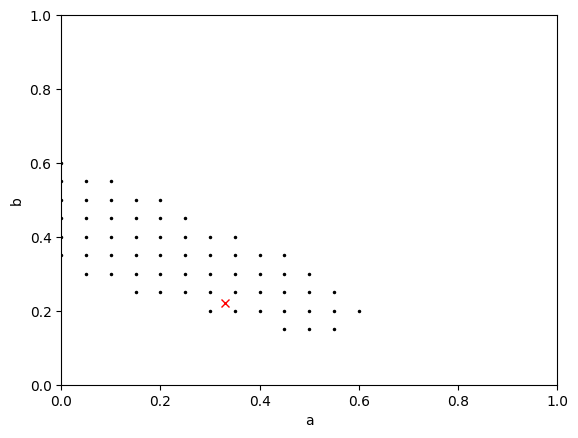

In [6]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ARMAX data gen

A = [1, -0.33]  # A(z^-1) = 1 - 0.33z^-1
B = [0.22]      # B(z^-1) = 0.22z^-1
C = [1, 0.15]   # C(z^-1) = 1 + 0.15z^-1
F = [0.31, 0.23] # F(z^-1) = 0.31 + 0.23z^-1
L = [1]        # L(z^-1) = 1
armax_model = ARMAX(A, B, C, F, L)

n_samples = 100
R = cp.sign(cp.sin(cp.linspace(0, 10*cp.pi, n_samples))) # square wave reference
Y, U, N, R = armax_model.simulate(n_samples, R, noise_std=0.2)
# armax_model.plot_results(Y, U, N, R)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SPS model definitions

A  = [1, -0.33]
B = [0, 0.22]
C = [1, 0.15]

G = (B, A)
H = (C, A)     
F = ([0.31, 0.23], [1])  
L = ([1], [1])         

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SPS model creation

m = 100
q = 5
model = SPS_indirect_model(m, q)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ confidence region

n_a = 1
n_b = 1
region_bounds = [[0, 1.0], [0, 1.0]]
granularity = [21, 21]

pts_in_conf_region = get_conf_region(region_bounds, granularity, model, n_a, n_b, C, L, F, Y, R)
# print(len(pts_in_conf_region))
# print(cp.prod(granularity))

# first order system
fig, axes = plt.subplots()
plot_pts_in_conf_region(pts_in_conf_region, x_dim=0, y_dim=1, true_param=[-A[1], B[1]], fig=fig, ax=axes)
axes.set_xlim(0,1)
axes.set_ylim(0,1)
axes.set_xlabel("a")
axes.set_ylabel("b")
plt.show()

##### example: n_a=2, n_b=2

1.6% of tested points were in confidence region
SPS indicator returns True with actual system parameters: True
Actual system parameters were in the returned confidence region: True


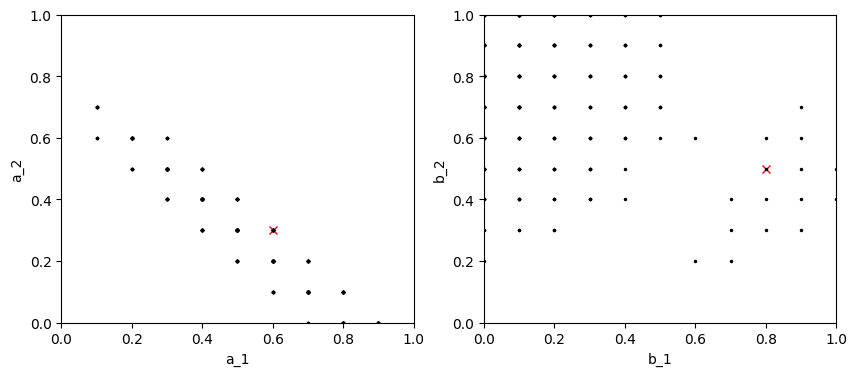

In [7]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ARMAX data gen example

A  = [1, -0.6, -0.3]
B = [0.8, 0.5]
C = [1, 0.2, 0.04]
F = [0.3, 0.2, 0.1] 
L = [1]
armax_model = ARMAX(A, B, C, F, L)

n_samples = 100
R = cp.sign(cp.sin(cp.linspace(0, 10*cp.pi, n_samples))) # square wave reference signal, works with both cupy and numpy
Y, U, N, R = armax_model.simulate(n_samples, R, noise_std=0.05)
# armax_model.plot_results(Y, U, N, R)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SPS model definitions

A  = [1, -0.6, -0.3]
B = [0, 0.8, 0.5]
C = [1, 0.2, 0.04]
G = (B, A)
H = (C, A)

F = ([0.3, 0.2, 0.1], [1])  
L = ([1], [1])         

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SPS model creation

m = 20
q = 1
model = SPS_indirect_model(m, q)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ get confidence region

n_a = 2
n_b = 2
region_bounds = [[0, 1.0], [0, 1.0], [0, 1.0], [0, 1.0]]
granularity = [11, 11, 11, 11]

pts_in_conf_region = get_conf_region(region_bounds, granularity, model, n_a, n_b, C, L, F, Y, R)
pct = 100 * len(pts_in_conf_region) / cp.prod(granularity)
print(f"{pct:.1f}% of tested points were in confidence region", )

G_0, H_0 = model.transform_to_open_loop(G, H, F, L)
in_sps, S1 = model.open_loop_sps(G_0, H_0, Y, R, n_a, n_b)
print(f"SPS indicator returns True with actual system parameters: {in_sps}")

target = cp.array([0.6, 0.3, 0.8, 0.5])
assert len(pts_in_conf_region) > 0
idx = cp.where(cp.all(cp.isclose(pts_in_conf_region, target, atol=1e-6), axis=1))
in_list = idx[0].size != 0
print(f"Actual system parameters were in the returned confidence region: {in_list}")

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ plot confidence region

%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(10,4))
plot_pts_in_conf_region(pts_in_conf_region, x_dim=0, y_dim=1, true_param=[-A[1], -A[2]], fig=fig, ax=axes[0])
axes[0].set_xlim(0,1)
axes[0].set_ylim(0,1)
axes[0].set_xlabel("a_1")
axes[0].set_ylabel("a_2")
plot_pts_in_conf_region(pts_in_conf_region, x_dim=2, y_dim=3, true_param=[B[1], B[2]], fig=fig, ax=axes[1])
axes[1].set_xlim(0,1)
axes[1].set_ylim(0,1)
axes[1].set_xlabel("b_1")
axes[1].set_ylabel("b_2")
plt.show()

##### example: n_a=2, n_b=1

In [8]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ARMAX data gen example

A  = [1, -0.6, -0.3]
B = [0.8]
C = [1, 0.2, 0.04]
F = [0.3, 0.2] 
L = [1]
armax_model = ARMAX(A, B, C, F, L)

n_samples = 200
R = cp.sign(cp.sin(cp.linspace(0, 5*cp.pi, n_samples))) # square wave reference signal, works with both cupy and numpy
Y, U, N, R = armax_model.simulate(n_samples, R, noise_std=0.05)
# armax_model.plot_results(Y, U, N, R)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SPS model definitions

A  = [1, -0.6, -0.3]
B = [0, 0.8]
C = [1, 0.2, 0.04]
G = (B, A)
H = (C, A)

F = ([0.3, 0.2], [1])
L = ([1], [1])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SPS model creation

m = 100
q = 5
model = SPS_indirect_model(m, q)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ get confidence region

n_a = 2
n_b = 1
region_bounds = [[-1, 1], [-1, 1], [-1, 1]]
granularity = [21, 21, 21]
# region_bounds = [[0.6, 0.8], [0.2, 0.4], [0.7, 0.9]]
# granularity = [21, 21, 21]

pts_in_conf_region = get_conf_region(region_bounds, granularity, model, n_a, n_b, C, L, F, Y, R)
pct = 100 * len(pts_in_conf_region) / cp.prod(granularity)
print(f"{pct:.1f}% of tested points were in confidence region", )

G_0, H_0 = model.transform_to_open_loop(G, H, F, L)
in_sps, S1 = model.open_loop_sps(G_0, H_0, Y, R, n_a, n_b)
print(f"SPS indicator returns True with actual system parameters: {in_sps}")

target = cp.array([0.6, 0.3, 0.8])
assert len(pts_in_conf_region) > 0
idx = cp.where(cp.all(cp.isclose(pts_in_conf_region, target, atol=1e-6), axis=1))
in_list = idx[0].size != 0
print(f"Actual system parameters were in the returned confidence region: {in_list}")


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ plot confidence region

plt.switch_backend('TkAgg')  # or 'Qt5Agg'

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pts_in_conf_region[:,0], pts_in_conf_region[:,1], pts_in_conf_region[:,2])
ax.scatter(-A[1], -A[2], B[1], 'r', s=100)
ax.set_xlabel('a_1')
ax.set_ylabel('a_2')
ax.set_zlabel('b_1')
# plt.show()

plt.show(block=True)

0.2% of tested points were in confidence region
SPS indicator returns True with actual system parameters: True
Actual system parameters were in the returned confidence region: True


##### Debugging